# Neutrophil Peak Count Normalization

**Created**: 18 March 2022

In [1]:
if (!requireNamespace("BiocManager", quietly=TRUE)) {
    install.packages("BiocManager")
}

if (!requireNamespace("limma", quietly=TRUE)) {
    BiocManager::install("limma")
}

if (!requireNamespace("edgeR", quietly=TRUE)) {
    BiocManager::install("edgeR")
}

if (!requireNamespace("UpSetR", quietly=TRUE)) {
    install.packages("UpSetR")
}

if (!requireNamespace("umap")) {
    install.packages("umap")
}

if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required namespace: umap

Loading required namespace: patchwork



In [2]:
library(tidyverse)
library(RColorBrewer)
library(data.table)
library(edgeR)
library(limma)
library(umap)
library(UpSetR)
library(parallel)
library(patchwork)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: limma



## Load Data

In [3]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_atac_seq.txt")

sample.info <- sample.info %>%
    dplyr::select(Group.ID, Donor, Lineage, Cell_type, Stimulated, Treatment) %>%
    dplyr::filter(grepl("Ram-Mohan", Donor)) %>%
    unique() %>%
    dplyr::mutate(Treatment = gsub("-", "", Treatment)) %>%
    dplyr::mutate(Donor = gsub("-", "", Donor)) %>%
    dplyr::arrange(Lineage, Cell_type, Treatment, Donor)

rownames(sample.info) <- sample.info$Group.ID

In [4]:
head(sample.info)

,Group.ID,Donor,Lineage,Cell_type,Stimulated,Treatment
,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>
Ram-Mohan-D1-Neutrophils-BGP,Ram-Mohan-D1-Neutrophils-BGP,RamMohanD1,MYELOID,Neutrophils,TRUE,BGP
Ram-Mohan-D2-Neutrophils-BGP,Ram-Mohan-D2-Neutrophils-BGP,RamMohanD2,MYELOID,Neutrophils,TRUE,BGP
Ram-Mohan-D3-Neutrophils-BGP,Ram-Mohan-D3-Neutrophils-BGP,RamMohanD3,MYELOID,Neutrophils,TRUE,BGP
Ram-Mohan-D4-Neutrophils-BGP,Ram-Mohan-D4-Neutrophils-BGP,RamMohanD4,MYELOID,Neutrophils,TRUE,BGP
Ram-Mohan-D1-Neutrophils-Control,Ram-Mohan-D1-Neutrophils-Control,RamMohanD1,MYELOID,Neutrophils,FALSE,Control
Ram-Mohan-D2-Neutrophils-Control,Ram-Mohan-D2-Neutrophils-Control,RamMohanD2,MYELOID,Neutrophils,FALSE,Control


In [5]:
peak.counts <- fread("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/neutrophil/peak_counts.tsv", header=T)

colnames(peak.counts) <- sapply(strsplit(colnames(peak.counts), "\\."), function(x) { x[1] })

peak.counts <- peak.counts %>%
    dplyr::select(GeneID, Chr, Start, End, Strand, all_of(sample.info$Group.ID))

In [6]:
head(peak.counts)

GeneID,Chr,Start,End,Strand,Ram-Mohan-D1-Neutrophils-BGP,Ram-Mohan-D2-Neutrophils-BGP,Ram-Mohan-D3-Neutrophils-BGP,Ram-Mohan-D4-Neutrophils-BGP,Ram-Mohan-D1-Neutrophils-Control,⋯,Ram-Mohan-D1-Neutrophils-R848,Ram-Mohan-D2-Neutrophils-R848,Ram-Mohan-D3-Neutrophils-R848,Ram-Mohan-D4-Neutrophils-R848,Ram-Mohan-D1-Neutrophils-SA-1,Ram-Mohan-D1-Neutrophils-SA-3,Ram-Mohan-D2-Neutrophils-SA-3,Ram-Mohan-D1-Neutrophils-SA-5,Ram-Mohan-D1-Neutrophils-WB,Ram-Mohan-D2-Neutrophils-WB
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1:827317-827808,1,827317,827808,+,10,9,30,4,3,⋯,65,8,91,44,5,14,22,25,11,58
1:869784-870190,1,869784,870190,+,9,15,46,16,11,⋯,47,2,219,112,33,22,89,42,19,84
1:904630-904875,1,904630,904875,+,10,18,16,16,8,⋯,24,4,94,40,15,15,39,24,8,43
1:913022-913344,1,913022,913344,+,17,4,14,6,8,⋯,16,7,43,21,25,15,12,42,12,27
1:913595-914626,1,913595,914626,+,16,15,33,25,13,⋯,32,15,42,30,93,66,31,113,94,32
1:918473-919352,1,918473,919352,+,18,26,31,22,10,⋯,35,16,50,38,63,67,41,94,51,37


In [7]:
tss.enrichment <- read.table("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/tss_enrichment_scores.tsv", header=T)

rownames(tss.enrichment) <- tss.enrichment$Sample

tss.enrichment <- tss.enrichment[sample.info$Group.ID, ]

In [8]:
head(tss.enrichment)

,Sample,TSS_Enrichment_Score
,<chr>,<dbl>
Ram-Mohan-D1-Neutrophils-BGP,Ram-Mohan-D1-Neutrophils-BGP,4.574170
Ram-Mohan-D2-Neutrophils-BGP,Ram-Mohan-D2-Neutrophils-BGP,4.698059
Ram-Mohan-D3-Neutrophils-BGP,Ram-Mohan-D3-Neutrophils-BGP,6.071191
Ram-Mohan-D4-Neutrophils-BGP,Ram-Mohan-D4-Neutrophils-BGP,4.193959
Ram-Mohan-D1-Neutrophils-Control,Ram-Mohan-D1-Neutrophils-Control,3.146917
Ram-Mohan-D2-Neutrophils-Control,Ram-Mohan-D2-Neutrophils-Control,2.649130


## Filter Samples

Filter samples based on their TSS Enrichment Scores. Specifically, remove any samples with TSS Enrichment Scores lower than 4.

In [9]:
good.samples <- tss.enrichment$Sample[tss.enrichment$TSS_Enrichment_Score > 4]

In [10]:
setdiff(tss.enrichment$Sample, good.samples)

[1] "Ram-Mohan-D1-Neutrophils-Control" "Ram-Mohan-D2-Neutrophils-Control"
 [3] "Ram-Mohan-D2-Neutrophils-FLAG"    "Ram-Mohan-D2-Neutrophils-HMGB1"  
 [5] "Ram-Mohan-D1-Neutrophils-LPS"     "Ram-Mohan-D2-Neutrophils-LPS"    
 [7] "Ram-Mohan-D1-Neutrophils-LTA"     "Ram-Mohan-D2-Neutrophils-LTA"    
 [9] "Ram-Mohan-D2-Neutrophils-R848"    "Ram-Mohan-D1-Neutrophils-SA-1"   
[11] "Ram-Mohan-D1-Neutrophils-SA-3"    "Ram-Mohan-D1-Neutrophils-SA-5"   
[13] "Ram-Mohan-D1-Neutrophils-WB"

In [11]:
sample.info <- sample.info[good.samples, ]

In [12]:
peak.counts <- peak.counts %>%
    dplyr::select(GeneID, Chr, Start, End, Strand, all_of(good.samples))

In [13]:
tss.enrichment <- tss.enrichment[good.samples, ]

## Limma-Voom Modeling

### Count Matrix

Set up the count matrix in the format required for Limma.

In [14]:
count.mtx <- as.matrix(peak.counts[,-(1:5)])
rownames(count.mtx) <- peak.counts$GeneID

### Create Sample Groups for Neutrophil Atlas

Biological groups will be defined by specific stimulation condition. The stimulation condition have a higher resolution in this study (multiple treatments across donors).

In [15]:
stimulated <- factor(sample.info$Treatment)
stimulated <- droplevels(stimulated)

Batch effects that I will correct for include donor and TSS Enrichment Score.

In [16]:
donors <- factor(sample.info$Donor)
donors <- droplevels(donors)
tss.score <- as.matrix(tss.enrichment$TSS_Enrichment_Score)

Design matrix for the neutrophil atlas.

In [17]:
design <- model.matrix(~0 + stimulated + donors + tss.score)

### Create DGEList

`edgeR` can be used to handle count matrices. We will use `voom` in the next step to process this `edgeR` object.

In [18]:
dge <- DGEList(count.mtx)

Filter peaks using in-build `edgeR` function.

In [19]:
keep <- filterByExpr(dge, design=design, min.count=50, min.total.count=200, min.prop=1)
dge <- dge[keep, , keep.lib.sizes=FALSE]

In [20]:
dim(dge)

[1] 65148    25

Calculate normalization factors for the trimmed mean of M-values method.

In [21]:
dge <- calcNormFactors(dge, method="TMM")

### Voom for Neutrophil Atlas

`voom` models a count matrix by empirically identifying the mean-variance relationship within the data. The count matrix can then be normalized and batch effects can be removed. The normalized data can be used in downstream analysis with `limma`.

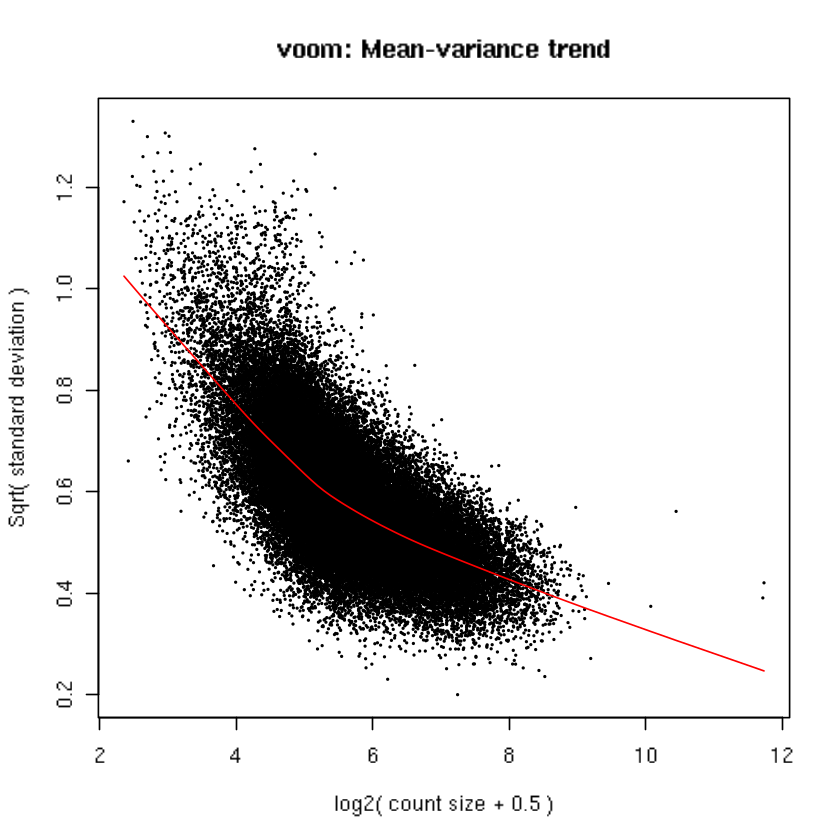

In [22]:
y <- voom(dge, design, plot=TRUE)

### Visualize Normalized Counts

In [23]:
y.r <- removeBatchEffect(y, batch=donors, covariates=tss.score)

In [24]:
pca <- prcomp(t(as.matrix(y.r)))

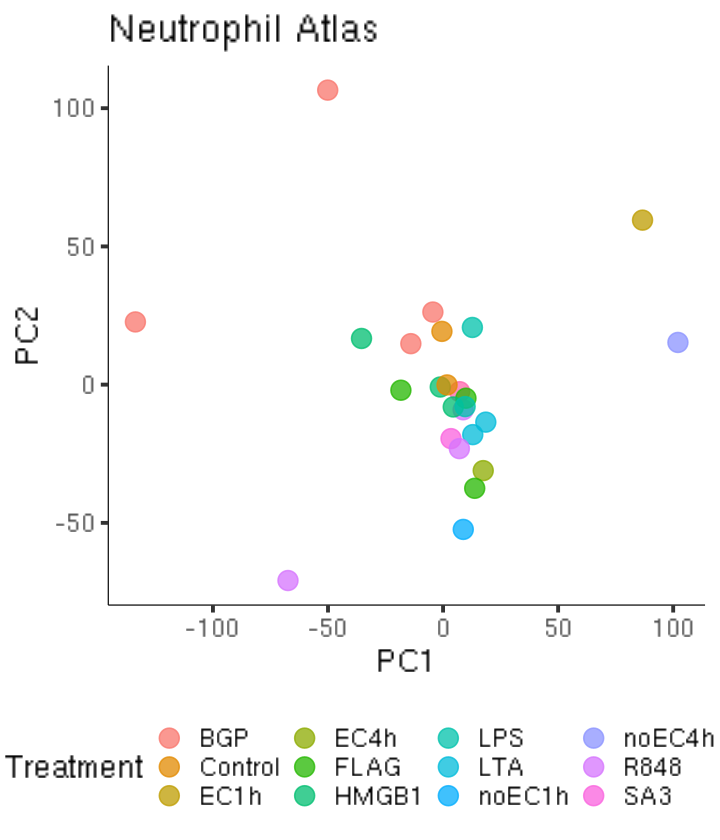

In [25]:
options(repr.plot.width=6, repr.plot.height=7)

merge(pca$x, sample.info, by.x=0, by.y="Group.ID") %>%
    as.data.frame() %>%
    ggplot() +
    geom_point(aes(x=PC1, y=PC2, color=Treatment), size=I(5), alpha=0.75) +
    ggtitle("Neutrophil Atlas") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/neutrophil_normalized_peak_count_pca.svg", width=6, height=7)

In [26]:
umap.res <- umap(scale(t(as.matrix(y.r))))

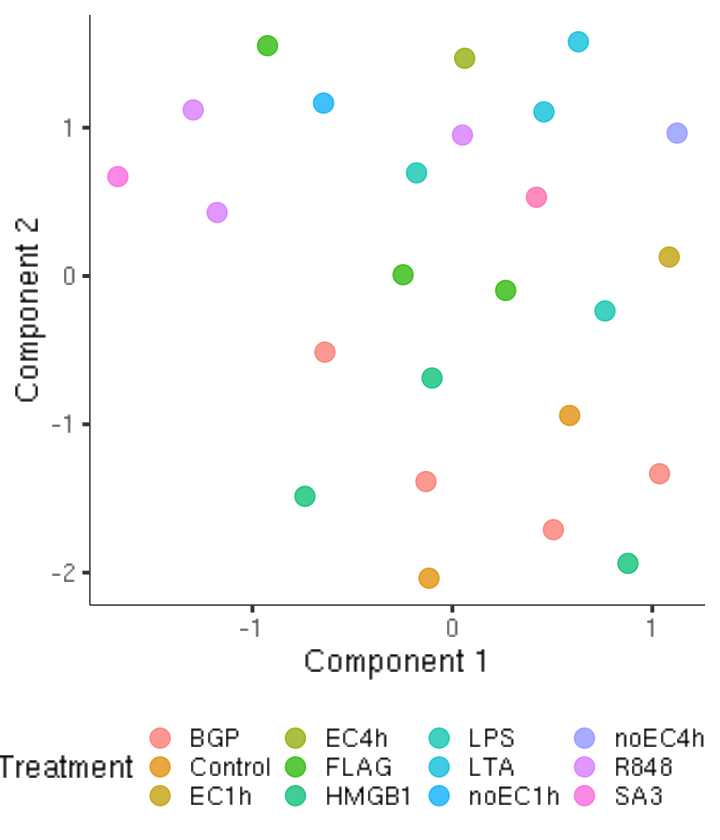

In [27]:
options(repr.plot.width=6, repr.plot.height=7)

umap.res$layout %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2) %>%
    dplyr::mutate(Group.ID=rownames(.)) %>%
    merge(., sample.info, by="Group.ID") %>%
    ggplot() +
    geom_point(aes(x=Comp1, y=Comp2, color=Treatment), size=I(5), alpha=0.75) +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme

### Limma Fit

Use `limma` to fit a linear model consisting of the biological `groups`.

In [28]:
fit <- lmFit(y, design)

### Limma DA Peaks

Create the contrast matrix. There are three sets of contrasts:

1. Neutrophil DAMP/PAMP Stimulation vs. Control
    1. LTA vs. Control (TLR2)
    2. LPS vs. Control (TLR4)
    3. FLAG vs. Control (TLR5)
    4. R848 vs. Control (TLR7/TLR8)
    5. BGP vs. Control (Dectin-1)
    6. HMGB1 vs. Control (TLR4)
2. Whole-Organism *S. aureus* in Whole Blood vs. Untreated Whole Blood
    2. $10^3$ Cells of *S. aureus* in Whole Blood vs. Untreated Whole Blood
3. Whole-Organism *E. coli* in Whole Blood vs. Untreated Whole Blood
    1. *E. coli* for 1 hour in Whole Blood vs. Untreated Whole Blood for 1 hour
    2. *E. coli* for 4 hours in Whole Blood vs. Untreated Whole Blood for 4 hours

In [29]:
contrast <- matrix(0, nrow=ncol(coef(fit)), ncol=8)
rownames(contrast) <- colnames(coef(fit))
colnames(contrast) <- c(
    "LTA-Control", "LPS-Control", "FLAG-Control", "R848-Control", "BGP-Control", "HMGB1-Control",
    "EC1h-noEC1h", "EC4h-noEC4h"
)

for (contrast.id in colnames(contrast)) {
    contrast[paste0("stimulated", gsub("-.*$", "", contrast.id)), contrast.id] = 1
    contrast[paste0("stimulated", gsub("^.*-", "", contrast.id)), contrast.id] = -1
}

In [30]:
da.peaks <- rbindlist(lapply(1:ncol(contrast), function(i) {
    de.res = eBayes(contrasts.fit(fit, contrast[,i]))
    de.res.table = topTable(de.res, sort.by="p", n=Inf)

    treatment = gsub("-.*$", "", colnames(contrast)[i])

    de.res.table %>%
        dplyr::mutate(Contrast=colnames(contrast)[i]) %>%
        dplyr::mutate(Treatment=treatment) %>%
        dplyr::mutate(Peak.ID=rownames(.)) %>%
        dplyr::mutate(Peak.Chr=sapply(strsplit(Peak.ID, ":"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.Coords=sapply(strsplit(Peak.ID, ":"), function(x) { x[2] })) %>%
        dplyr::mutate(Peak.Start=sapply(strsplit(Peak.Coords, "-"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.End=sapply(strsplit(Peak.Coords, "-"), function(x) { x[2] })) %>%
        dplyr::select(Contrast, Treatment, Peak.ID, Peak.Chr, Peak.Start, Peak.End, logFC, AveExpr, t, P.Value, adj.P.Val, B)
}))

## Differentially Accessible Peaks

Calculate differentially accessible peaks. For each contrast, a peak is considered differentially accessible if the adjusted P-value is < 0.05 and the absolute log fold change is greater than 1.

In [31]:
da.peak.set <- da.peaks %>%
    dplyr::filter(adj.P.Val < 0.01) %>%
    dplyr::filter(abs(logFC) > 1)

write.csv(da.peak.set, "~/gains_team282/epigenetics/accessibility/analysis/atac_seq/neutrophil/da_peak_set.csv")

There are 129 peaks that are DA peaks in at least one treatment for neutrophils.

In [32]:
length(unique(da.peak.set$Peak.ID))

[1] 151

In [33]:
table(da.peak.set$Treatment)


 BGP EC1h EC4h FLAG R848 
   2   26   53   13   75 

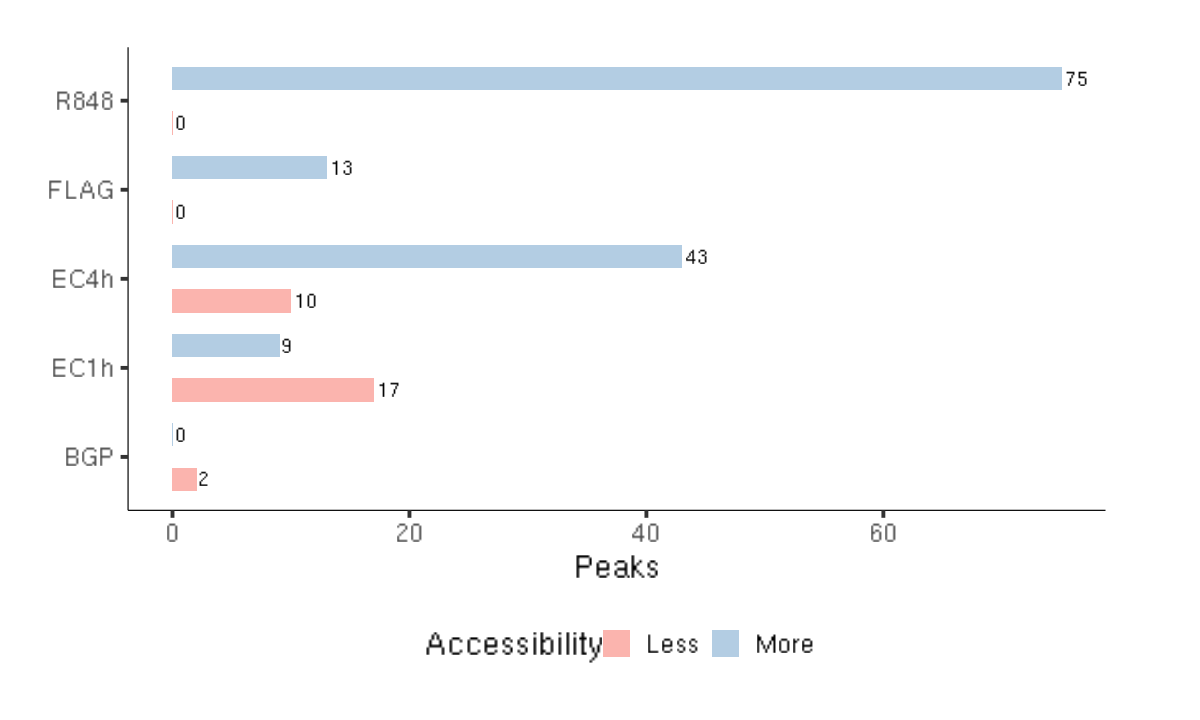

In [34]:
options(repr.plot.width=10, repr.plot.height=6)

da.peak.set %>%
    dplyr::mutate(Accessibility=factor(ifelse(logFC > 1, "More", "Less"))) %>%
    dplyr::group_by(Treatment, Accessibility) %>%
    dplyr::summarize(Peaks=n(), .groups="drop") %>%
    tidyr::spread(Accessibility, Peaks, fill=0) %>%
    tidyr::gather("Accessibility", "Peaks", -Treatment) %>%
    ggplot() +
    geom_bar(aes(x=Treatment, y=Peaks, fill=Accessibility), stat="identity", width=0.5, position=position_dodge(width=1)) +
    geom_text(aes(x=Treatment, y=Peaks, label=Peaks, group=Accessibility), hjust=-0.2, vjust=0.5, position=position_dodge(width=1)) +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip(clip="off") +
    ggplot_theme +
    theme(axis.title.y.left=element_blank(), plot.margin=margin(1, 2, 1, 1, "cm"))

ggsave("03_Functional_Interpretation/results/neutrophil_da_peak_counts.pdf", width=10, height=6)

In [35]:
da.peak.set %>%
    dplyr::mutate(Accessible=ifelse(logFC > 1, "More", "Less")) %>%
    dplyr::count(Peak.ID, Accessible) %>%
    tidyr::spread(Accessible, n, fill=0) %>%
    dplyr::filter(More + Less > 1) %>%
    dplyr::mutate(Both=(More > 0) & (Less > 0)) %>%
    dplyr::count(Both) %>%
    dplyr::mutate(Total = sum(n)) %>%
    dplyr::mutate(Prop = n / Total)

Both,n,Total,Prop
<lgl>,<int>,<int>,<dbl>
FALSE,17,17,1
